In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [2]:
# Hodgkin-Huxley model
# https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model
class HHModel:

    class Gate:
        alpha, beta, state = 0, 0, 0

        def update(self, deltaTms):
            alphaState = self.alpha * (1-self.state)
            betaState = self.beta * self.state
            self.state += deltaTms * (alphaState - betaState)

        def setInfiniteState(self):
            self.state = self.alpha / (self.alpha + self.beta)

    ENa, EK, EKleak = 115, -12, 10.6
    gNa, gK, gKleak = 120, 36, 0.3
    m, n, h = Gate(), Gate(), Gate()
    Cm = 1

    def __init__(self, startingVoltage=0):
        self.Vm = startingVoltage
        self.UpdateGateTimeConstants(startingVoltage)
        self.m.setInfiniteState()
        self.n.setInfiniteState()
        self.h.setInfiniteState()
        self.INa = 0
        self.IK  = 0
        self.IKleak = 0
        self.Isum = 0

    def UpdateGateTimeConstants(self, Vm):
        self.n.alpha = .01 * ((10-Vm) / (np.exp((10-Vm)/10)-1))
        self.n.beta = .125*np.exp(-Vm/80)
        self.m.alpha = .1*((25-Vm) / (np.exp((25-Vm)/10)-1))
        self.m.beta = 4*np.exp(-Vm/18)
        self.h.alpha = .07*np.exp(-Vm/20)
        self.h.beta = 1/(np.exp((30-Vm)/10)+1)

    def UpdateCellVoltage(self, stimulusCurrent, deltaTms):
        self.INa = np.power(self.m.state, 3) * self.gNa * \
                   self.h.state*(self.Vm-self.ENa)
        self.IK = np.power(self.n.state, 4) * self.gK * (self.Vm-self.EK)
        self.IKleak = self.gKleak * (self.Vm-self.EKleak)
        self.Isum = stimulusCurrent - self.INa - self.IK - self.IKleak
        self.Vm += deltaTms * self.Isum / self.Cm

    def UpdateGateStates(self, deltaTms):
        self.n.update(deltaTms)
        self.m.update(deltaTms)
        self.h.update(deltaTms)

    def Iterate(self, stimulusCurrent=0, deltaTms=0.05):
        self.UpdateGateTimeConstants(self.Vm)
        self.UpdateCellVoltage(stimulusCurrent, deltaTms)
        self.UpdateGateStates(deltaTms)

In [3]:
hh = HHModel()
pointCount = 5000
Vm = np.empty(pointCount)
n = np.empty(pointCount)
m = np.empty(pointCount)
h = np.empty(pointCount)
INa = np.empty(pointCount)
IK = np.empty(pointCount)
IKleak = np.empty(pointCount)
Isum = np.empty(pointCount)
times = np.arange(pointCount) * 0.05
stim = np.zeros(pointCount)
stim[2000:3000] = 10

In [4]:
for i in range(len(times)):
    hh.Iterate(stimulusCurrent=stim[i], deltaTms=0.05)
    Vm[i] = hh.Vm
    n[i]  = hh.n.state
    m[i]  = hh.m.state
    h[i]  = hh.h.state
    INa[i] = hh.INa
    IK[i] = hh.IK
    IKleak[i] = hh.IKleak
    Isum[i] = hh.Isum

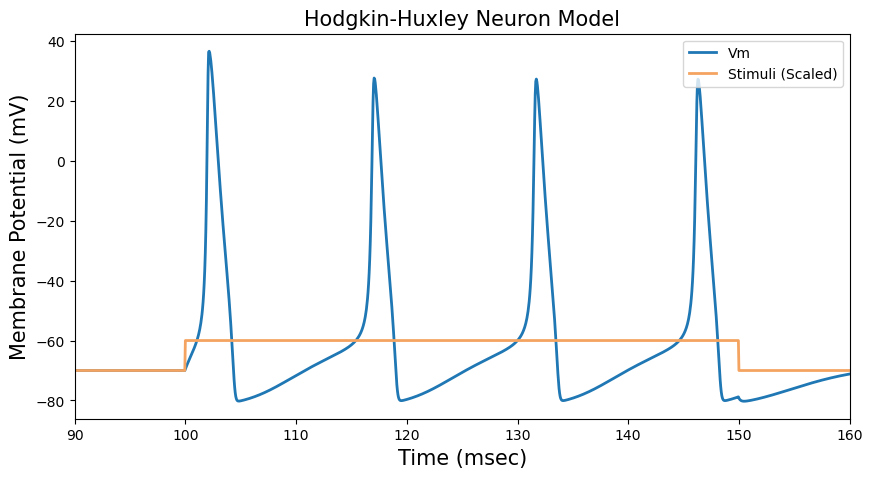

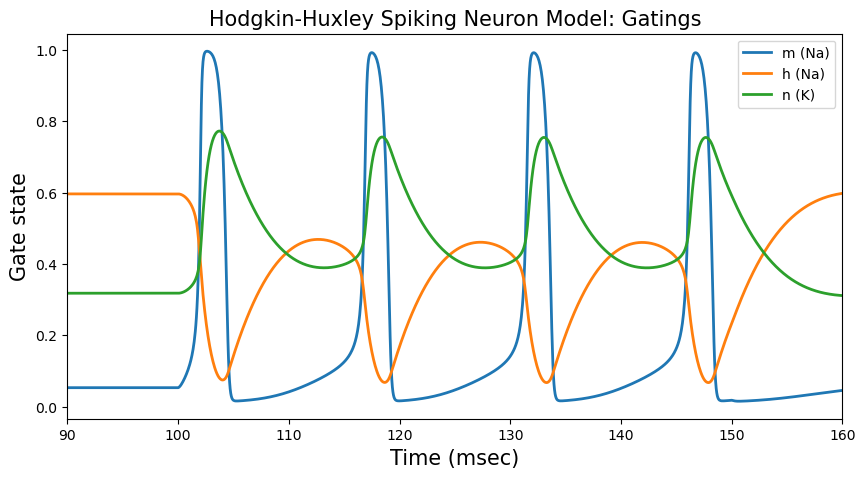

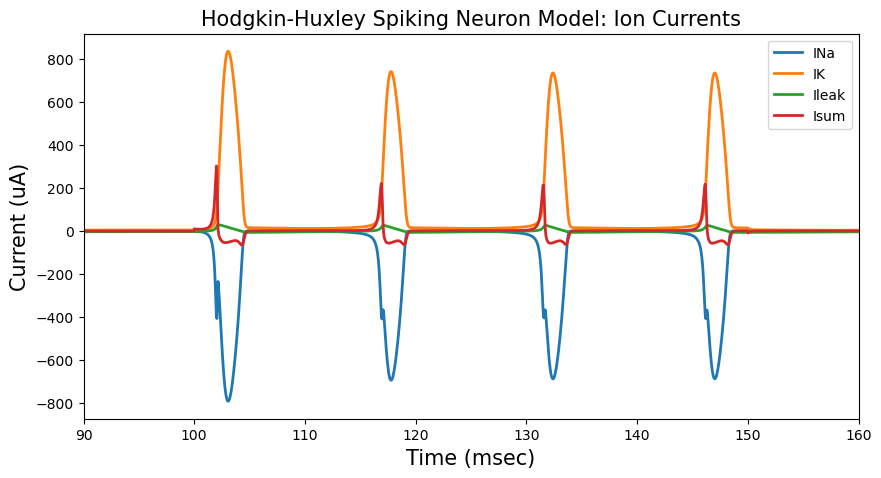

In [7]:
plt.figure(figsize=(10,5))
plt.plot(times, Vm - 70, linewidth=2, label='Vm')
plt.plot(times, stim - 70, label = 'Stimuli (Scaled)', linewidth=2, color='sandybrown')
plt.ylabel("Membrane Potential (mV)", fontsize=15)
plt.xlabel('Time (msec)', fontsize=15)
plt.xlim([90,160])
plt.title("Hodgkin-Huxley Neuron Model", fontsize=15)
plt.legend(loc=1)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(times, m, label='m (Na)', linewidth=2)
plt.plot(times, h, label='h (Na)', linewidth=2)
plt.plot(times, n, label='n (K)', linewidth=2)
plt.ylabel("Gate state", fontsize=15)
plt.xlabel('Time (msec)', fontsize=15)
plt.xlim([90,160])
plt.title("Hodgkin-Huxley Spiking Neuron Model: Gatings", fontsize=15)
plt.legend(loc=1)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(times, INa, label='INa', linewidth=2)
plt.plot(times, IK, label='IK', linewidth=2)
plt.plot(times, IKleak, label='Ileak', linewidth=2)
plt.plot(times, Isum, label='Isum', linewidth=2)
plt.ylabel("Current (uA)", fontsize=15)
plt.xlabel('Time (msec)', fontsize=15)
plt.title("Hodgkin-Huxley Spiking Neuron Model: Ion Currents", fontsize=15)
plt.xlim([90,160])
plt.legend(loc=1)
plt.show()